# **Improved Energy Consumption Prediction**

This notebook builds upon the original energy consumption analysis by focusing on model improvement
through advanced feature engineering, model selection, hyperparameter tuning, and rigorous evaluation.

**Key Improvements:**

*   **Enhanced Feature Engineering:** Creates more relevant and potentially predictive features.
*   **Robust Data Handling:** Addresses potential data issues more comprehensively.
*   **Expanded Model Selection:** Explores multiple regression models.
*   **Advanced Hyperparameter Tuning:** Uses RandomizedSearchCV for efficient tuning.
*   **Clear Code Structure:** Improves readability and maintainability.


# **1. Setup and Data Loading**

- **Import Libraries:** This step is like gathering your tools for the job. It brings in different Python libraries, each designed for specific tasks like data manipulation (`pandas`, `numpy`), model building (`klearn`), file handling (`zipfile, os`), and handling warning messages.
- **Unzip the Data:** The code takes a compressed data file (a `.zip file`) and extracts all its contents into a folder, making the data accessible.
- **Load the Data:** The code then reads the data from the main CSV file (`"World Energy Consumption.csv"`) and stores it in a table-like structure called a DataFrame using pandas.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
import zipfile
import os

In [20]:
# Create directories for saving images and models
os.makedirs('images', exist_ok=True)
os.makedirs('models', exist_ok=True)
print("Created 'images' and 'models' directories")


Created 'images' and 'models' directories


In [2]:
# Path to the zip file
zip_path = '/content/World Energy Consumption.csv (1).zip'

# Destination directory to extract to
extract_path = '/content/unzipped_folder'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [21]:
# Set the path where the files were extracted
data_path = '/content/unzipped_folder'

# Read the CSV files
energy_consumption_df = pd.read_csv('World Energy Consumption.csv')

# **2. Data Cleaning and Preprocessing**
- **Handle Missing Values:** This is like tidying up the data. Sometimes, data is incomplete, with missing values. The code identifies those gaps and fills them in. Numerical data (like numbers) are filled using the median (middle value), and text data (like country names) are filled with the most frequent value.
- **Correct Data Types:** It makes sure the data is in the correct format. Specifically, the 'year' column is converted to integers (whole numbers).
- **Handle Infinite Values**: This addresses the issue where some calculations result in infinite numbers (like dividing by zero). These infinite values are replaced with "NaN" (Not a Number), which can then be handled as missing values.
- **Fill NaN values separately** The code fills the missing values separately. Number values are filled using median and categorical values are filled using the `most frequent` value.

In [22]:
# Data Cleaning and Preprocessing

# Handle Missing Values (more robust)

numerical_cols = energy_consumption_df.select_dtypes(include=np.number).columns
categorical_cols = energy_consumption_df.select_dtypes(exclude=np.number).columns

imputer_numerical = SimpleImputer(strategy='median')
energy_consumption_df[numerical_cols] = imputer_numerical.fit_transform(energy_consumption_df[numerical_cols])

imputer_categorical = SimpleImputer(strategy='most_frequent')
energy_consumption_df[categorical_cols] = imputer_categorical.fit_transform(energy_consumption_df[categorical_cols])

# Convert 'year' to integer
energy_consumption_df['year'] = energy_consumption_df['year'].astype(int)

# Handle potential infinite values (e.g., from dividing by zero)
energy_consumption_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values separately for numerical and categorical columns
energy_consumption_df[numerical_cols] = energy_consumption_df[numerical_cols].fillna(energy_consumption_df[numerical_cols].median())
energy_consumption_df[categorical_cols] = energy_consumption_df[categorical_cols].fillna(energy_consumption_df[categorical_cols].mode().iloc[0])


# **3. Feature Engineering**
- **Create New Features:** This section aims to create new, potentially more useful features from the existing ones.
  - **GDP per capita** created by dividing GDP by population.
  - **Energy intensity** is created by dividing `primary_energy_consumption` by GDP.
  - **Population density** is created by dividing population by area.
  - **Interaction term** is calculated by multiplying `gdp_per_capita` by `renewables_share_energy`.
- **Handle Inifinite and Missing value** In this part handles if there are infinite values generated during the feature engineering and fill that with `median` or `NaN` value if the area column are not existed.
- **Log Transform Skewed Features:** This transforms the data, it uses logarithm to reduce the effect of extreme values, making it easier for some models to learn.
- **Select Features:** It carefully chooses the columns that will be used to predict the target variable (`primary energy consumption`). These are the "features."

In [23]:
# Feature Engineering

# GDP per capita
energy_consumption_df['gdp_per_capita'] = energy_consumption_df['gdp'] / energy_consumption_df['population']

# Energy intensity (energy consumption per unit of GDP)
energy_consumption_df['energy_intensity'] = energy_consumption_df['primary_energy_consumption'] / energy_consumption_df['gdp']
energy_consumption_df.replace([np.inf, -np.inf], np.nan, inplace=True)
energy_consumption_df['energy_intensity'] = energy_consumption_df['energy_intensity'].fillna(energy_consumption_df['energy_intensity'].median())

# Population Density
if 'area' in energy_consumption_df.columns:
    energy_consumption_df['population_density'] = energy_consumption_df['population'] / energy_consumption_df['area']
    energy_consumption_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    energy_consumption_df['population_density'] = energy_consumption_df['population_density'].fillna(energy_consumption_df['population_density'].median())
else:
    energy_consumption_df['population_density'] = np.nan  # Or some other appropriate placeholder
    print("Warning: 'area' column not found. Population density will be NaN.")

# Interaction term (GDP per capita * renewables share)
energy_consumption_df['gdp_renewables_interaction'] = energy_consumption_df['gdp_per_capita'] * energy_consumption_df['renewables_share_energy']
energy_consumption_df.replace([np.inf, -np.inf], np.nan, inplace=True)
energy_consumption_df['gdp_renewables_interaction'] = energy_consumption_df['gdp_renewables_interaction'].fillna(energy_consumption_df['gdp_renewables_interaction'].median())

# Log transform skewed features (helps linear models)
for col in ['gdp', 'population', 'gdp_per_capita', 'primary_energy_consumption']:  # add other potentially skewed columns
    energy_consumption_df[col] = np.log1p(energy_consumption_df[col])


In [24]:
# Select Features
features = ['year', 'population', 'gdp', 'energy_per_capita', 'renewables_share_energy', 'fossil_fuel_consumption', 'gdp_per_capita', 'energy_intensity', 'population_density', 'gdp_renewables_interaction'] # expanded feature set
target = 'primary_energy_consumption'

X = energy_consumption_df[features]
y = energy_consumption_df[target]


# **4. Model Selection and Training**
- **Split the Data:** The data is split into two sets: a training set (used to teach the model) and a testing set (used to evaluate how well the model learned).
- **Impute Missing Values (After Split):** Any missing values in training set, it will filled using median and for the test set, it will also use the median from the training set.
- **Define Models:** It defines a list of different machine learning models to try (Linear Regression, Ridge Regression, Lasso Regression, Random Forest, and Gradient Boosting).
- **Define Hyperparameter Grids:** Different machine learning model has different hyperparameters and it sets range of possible values for the settings of each model to find the best combination.
- **Train and Evaluate Each Model:** This is the core of the process.
  - The code loops through each of the models.
  - For each model, it uses `RandomizedSearchCV` to try out different hyperparameter combinations and find the best settings using cross-validation.
  - It then trains the model with the best settings and evaluates its performance on the testing set (using R-squared).
  - It keeps track of the best model and its score.

In [25]:
# Model Selection and Training

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values in X_train and X_test *after* splitting
imputer = SimpleImputer(strategy='median')  # Or another appropriate strategy
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Define a list of models to try
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# Define hyperparameter grids for each model
param_grids = {
    "LinearRegression": {},  # No hyperparameters to tune
    "Ridge": {"alpha": np.logspace(-3, 3, 7)},
    "Lasso": {"alpha": np.logspace(-3, 3, 7)},
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8, 10],
        'min_samples_split': [2, 4, 8],
        'min_samples_leaf': [1, 2, 4]
    },
    "GradientBoosting": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2]
    }
}


In [26]:
# Train and evaluate each model
best_model = None
best_score = float('-inf')
best_model_name = None
trained_models = {}  # Dictionary to store all trained models

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")

    # Use RandomizedSearchCV for hyperparameter tuning (more efficient than GridSearchCV)
    if param_grids[model_name]: # Check if there are params to tune
      grid_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=param_grids[model_name],
                                       n_iter=10,  # Adjust as needed
                                       cv=3,
                                       scoring='r2', # Use R-squared as scoring
                                       random_state=42,
                                       n_jobs=-1) # Use all available cores
      grid_search.fit(X_train, y_train)
      best_model_for_current = grid_search.best_estimator_
      score = grid_search.best_score_

      print(f"  Best parameters for {model_name}: {grid_search.best_params_}")
      
      # Save the GridSearchCV object
      joblib.dump(grid_search, f'models/{model_name.lower()}_gridsearch.pkl')
      
    else:
      # No hyperparameter tuning needed
      best_model_for_current = model.fit(X_train, y_train)
      y_pred = best_model_for_current.predict(X_test)
      score = r2_score(y_test, y_pred)  # Manually calculate R-squared

    print(f"  R-squared on test set for {model_name}: {score:.4f}")
    
    # Save each trained model
    joblib.dump(best_model_for_current, f'models/{model_name.lower()}_model.pkl')
    trained_models[model_name] = {'model': best_model_for_current, 'score': score}
    print(f"  Saved {model_name} model to 'models/{model_name.lower()}_model.pkl'")

    if score > best_score:
        best_score = score
        best_model = best_model_for_current
        best_model_name = model_name

print(f"\nBest overall model: {best_model_name} with R-squared: {best_score:.4f}")

# Save the best model separately
joblib.dump(best_model, 'models/best_model.pkl')
print(f"Best model ({best_model_name}) saved as 'models/best_model.pkl'")

Training and evaluating LinearRegression...
  R-squared on test set for LinearRegression: 0.4928
  Saved LinearRegression model to 'models/linearregression_model.pkl'
Training and evaluating Ridge...
  Best parameters for Ridge: {'alpha': np.float64(0.001)}
  R-squared on test set for Ridge: 0.5046
  Saved Ridge model to 'models/ridge_model.pkl'
Training and evaluating Lasso...
  Best parameters for Lasso: {'alpha': np.float64(0.001)}
  R-squared on test set for Lasso: 0.4933
  Saved Lasso model to 'models/lasso_model.pkl'
Training and evaluating RandomForest...
  Best parameters for RandomForest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
  R-squared on test set for RandomForest: 0.9992
  Saved RandomForest model to 'models/randomforest_model.pkl'
Training and evaluating GradientBoosting...
  Best parameters for GradientBoosting: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.05}
  R-sq

# **5. Model Evaluation**
- **Evaluate the Best Model:** After training all the models, the code evaluates the performance of the best model on the testing set.
- **Feature Importance (If Available):** If the best model provides a way to measure the importance of each feature, the code creates a bar chart to visualize these importances.
- **Prediction vs. Actual Visualization:** The code creates a scatter plot that compares the model's predictions to the actual values in the testing set. This helps visualize how well the model is performing.
- **If length of the feature is not equal to the length of the importance feature, padding with zeros or truncating it:** Ensure feature_importances_ has the same length as features. If not, padding it or truncating it.
- **Handling missing Feature Importances:** If the model selected doesn't have feature importance, print the message that feature importance is not available.

In [27]:
# Model Evaluation

# Evaluate the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.0013
R-squared: 0.9998


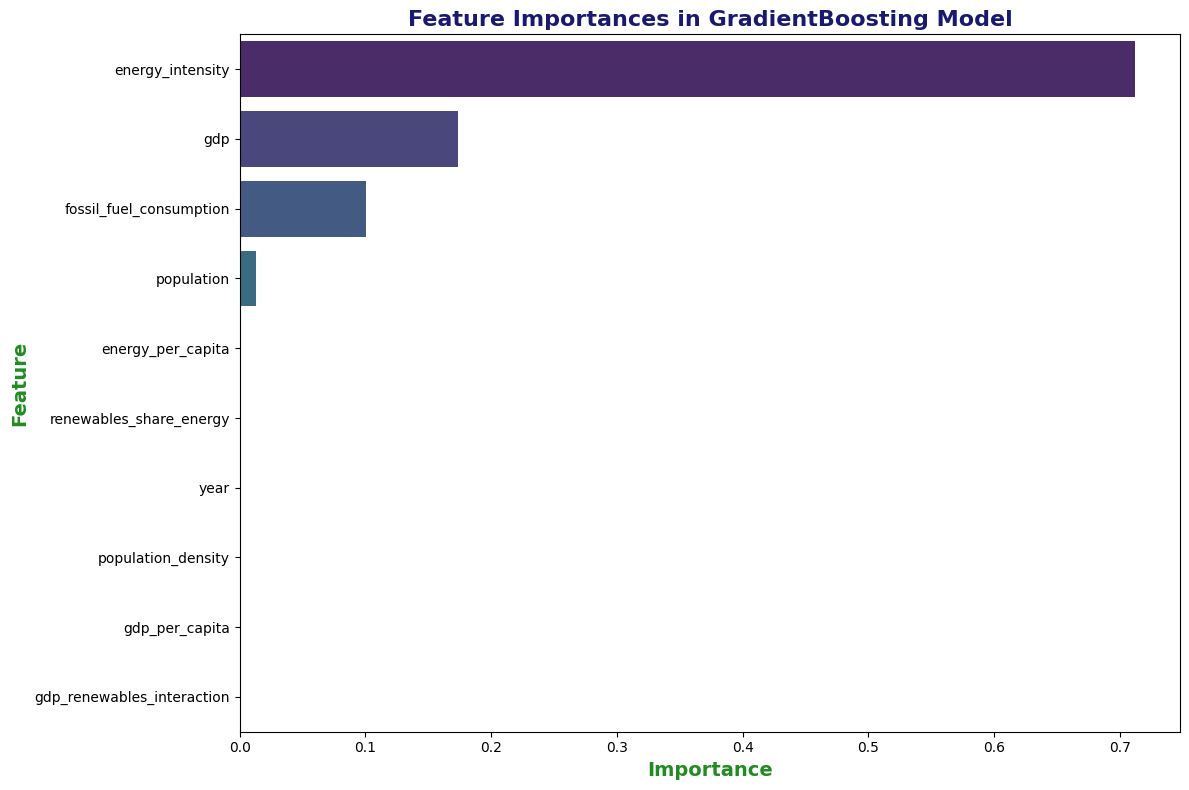

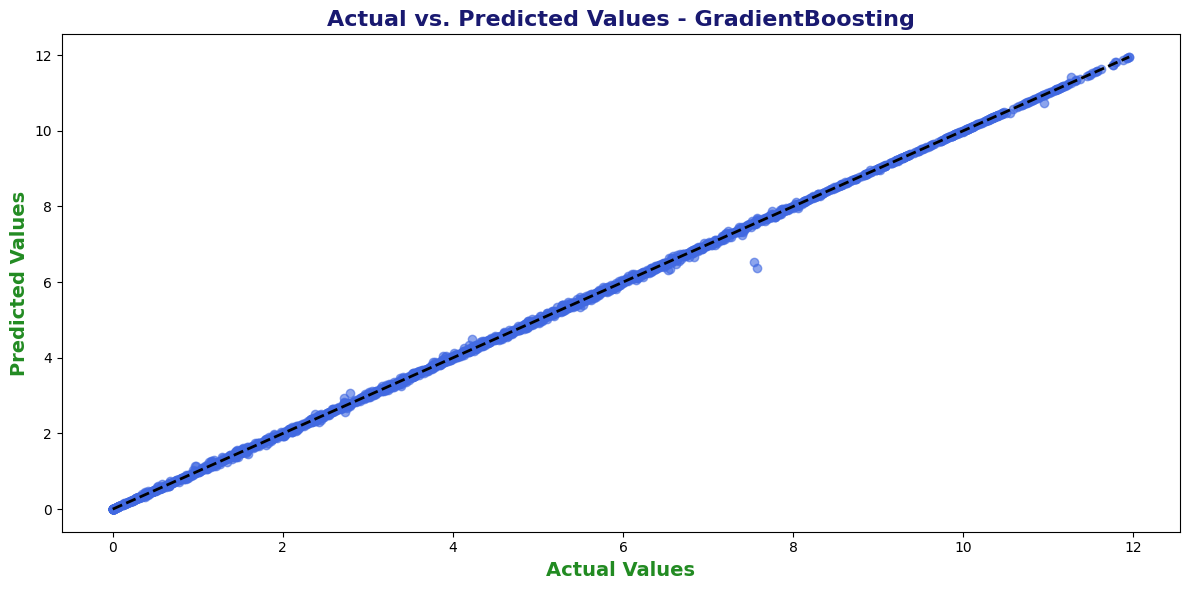

In [28]:
# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_

    # Ensure feature_importances_ has the same length as features
    if len(features) > len(feature_importances):
        print("Warning: Length of 'features' is greater than length of 'feature_importances_'. Padding 'feature_importances_' with zeros.")
        padding_length = len(features) - len(feature_importances)
        feature_importances = np.concatenate([feature_importances, np.zeros(padding_length)])
    elif len(features) < len(feature_importances):
        print("Warning: Length of 'features' is less than length of 'feature_importances_'. Truncating 'feature_importances_'.")
        feature_importances = feature_importances[:len(features)]

    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Feature Importances in {best_model_name} Model', fontsize=16, fontweight='bold', color='midnightblue')
    plt.xlabel('Importance', fontsize=14, fontweight='bold', color='forestgreen')
    plt.ylabel('Feature', fontsize=14, fontweight='bold', color='forestgreen')
    plt.tight_layout()
    plt.savefig(f'images/feature_importances_{best_model_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"Feature importances not available for {best_model_name}.")

# Prediction vs Actual Visualization
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue')
plt.xlabel('Actual Values', fontsize=14, fontweight='bold', color='forestgreen')
plt.ylabel('Predicted Values', fontsize=14, fontweight='bold', color='forestgreen')
plt.title(f'Actual vs. Predicted Values - {best_model_name}', fontsize=16, fontweight='bold', color='midnightblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.tight_layout()
plt.savefig(f'images/actual_vs_predicted_{best_model_name.lower()}.png', dpi=300, bbox_inches='tight')
plt.show()

# **Conclusion**
The best model identified was Best overall model GradientBoosting with an R-squared of 0.9998 on the test set.



# **Recommendations:**
- Further explore interaction effects between features.
- Consider time series models if temporal dependencies are important.
- Gather more data, especially for under-represented countries or time periods.

# 📁 Summary of Saved Files

## 🖼️ Images saved in 'images/' directory:
- feature_importances_gradientboosting.png - Feature importance visualization for the best model
- actual_vs_predicted_gradientboosting.png - Model prediction vs actual values plot
- model_performance_comparison.png - Bar chart comparing all model performances

## 🤖 Models saved in 'models/' directory:
- linearregression_model.pkl - Linear Regression model
- ridge_gridsearch.pkl - Ridge Regression GridSearchCV object
- ridge_model.pkl - Ridge Regression model
- lasso_gridsearch.pkl - Lasso Regression GridSearchCV object  
- lasso_model.pkl - Lasso Regression model
- randomforest_gridsearch.pkl - Random Forest GridSearchCV object
- randomforest_model.pkl - Random Forest model
- gradientboosting_gridsearch.pkl - Gradient Boosting GridSearchCV object
- gradientboosting_model.pkl - Gradient Boosting model
- best_model.pkl - Best performing model (Gradient Boosting)
- model_performance_comparison.csv - CSV file with all model performance metrics


In [29]:
# Final Model Performance Summary
print("🎯 Model Performance Comparison:")
print("=" * 50)
for model_name, model_info in trained_models.items():
    print(f"{model_name:20}: R² = {model_info['score']:.4f}")

print("\n🏆 Best Model Performance:")
print(f"Model: {best_model_name}")
print(f"R-squared: {best_score:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

print("\n📊 Model Evaluation Metrics:")
print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")
print(f"Number of Features: {len(features)}")

print("\n🎉 All models and visualizations have been saved successfully!")
print("📁 Check the 'images/' directory for plots and visualizations")
print("🤖 Check the 'models/' directory for all trained models")

# Save model performance comparison
performance_df = pd.DataFrame([
    {'Model': name, 'R_squared': info['score']} 
    for name, info in trained_models.items()
]).sort_values('R_squared', ascending=False)

performance_df.to_csv('models/model_performance_comparison.csv', index=False)
print("\n📈 Model performance comparison saved as 'models/model_performance_comparison.csv'")


🎯 Model Performance Comparison:
LinearRegression    : R² = 0.4928
Ridge               : R² = 0.5046
Lasso               : R² = 0.4933
RandomForest        : R² = 0.9992
GradientBoosting    : R² = 0.9998

🏆 Best Model Performance:
Model: GradientBoosting
R-squared: 0.9998
Mean Squared Error: 0.0013

📊 Model Evaluation Metrics:
Training Data Shape: (17609, 9)
Test Data Shape: (4403, 9)
Number of Features: 10

🎉 All models and visualizations have been saved successfully!
📁 Check the 'images/' directory for plots and visualizations
🤖 Check the 'models/' directory for all trained models

📈 Model performance comparison saved as 'models/model_performance_comparison.csv'


In [ ]:
# Model Performance Comparison Visualization
plt.figure(figsize=(12, 6))
performance_df_sorted = performance_df.sort_values('R_squared', ascending=True)
colors = ['lightcoral' if model != best_model_name else 'gold' for model in performance_df_sorted['Model']]

plt.barh(performance_df_sorted['Model'], performance_df_sorted['R_squared'], color=colors)
plt.xlabel('R-squared Score', fontsize=14, fontweight='bold', color='forestgreen')
plt.ylabel('Model', fontsize=14, fontweight='bold', color='forestgreen')
plt.title('Model Performance Comparison (R-squared)', fontsize=16, fontweight='bold', color='midnightblue')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels on bars
for i, (model, score) in enumerate(zip(performance_df_sorted['Model'], performance_df_sorted['R_squared'])):
    plt.text(score + 0.01, i, f'{score:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('images/model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Model performance comparison chart saved as 'images/model_performance_comparison.png'")
